In [1]:
import umap as umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("white")
%matplotlib widget

In [47]:
class DataCursor(object):
    text_template = 'x: %0.2f\ny: %0.2f'
    x, y = 0.0, 0.0
    xoffset, yoffset = -20, 20
    text_template = 'x: %0.2f\ny: %0.2f'

    def __init__(self, ax):
        self.ax = ax
        self.annotation = ax.annotate(self.text_template, 
                xy=(self.x, self.y), xytext=(self.xoffset, self.yoffset), 
                textcoords='offset points', ha='right', va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0')
                )
        self.annotation.set_visible(False)

    def __call__(self, event):
        self.event = event
        # xdata, ydata = event.artist.get_data()
        # self.x, self.y = xdata[event.ind], ydata[event.ind]
        self.x, self.y = event.mouseevent.xdata, event.mouseevent.ydata
        if self.x is not None:
            self.annotation.xy = self.x, self.y
            self.annotation.set_text(self.text_template % (self.x, self.y))
            self.annotation.set_visible(True)
            event.canvas.draw()
        return event

# https://stackoverflow.com/questions/4652439/is-there-a-matplotlib-equivalent-of-matlabs-datacursormode

In [2]:
def pDose(x):
    '''This is just a helper function, to compute easily log transformed concentrations used in drug discovery'''
    return(-np.log10(1e-6*x))

In [3]:
BaseDir = "./results/"

In [4]:
# Import feature data after QC
selected_df = pd.read_csv("{}colopaint44_selected_data.csv".format(BaseDir), sep=";", index_col=0)
ListOfMetadata = list(selected_df.columns[selected_df.columns.str.contains("Metadata_")])
selected_df.head(1)

,Metadata_layout_id,Metadata_well_id,Metadata_cmpd,Metadata_batch_id,Metadata_solvent,Metadata_stock_conc,Metadata_stock_conc_unit,Metadata_cmpd_vol,Metadata_cmpd_vol_unit,Metadata_well_vol,...,RadialDistribution_ZernikePhase_illumCONC_8_2_cells_MAD,Correlation_Overlap_illumHOECHST_illumPHAandWGA_cells_MAD,RadialDistribution_ZernikePhase_illumSYTO_2_0_cells_MAD,AreaShape_Zernike_4_0_nuclei_MAD,RadialDistribution_ZernikePhase_illumMITO_1_1_cells,Granularity_5_illumHOECHST_cells_MAD,RadialDistribution_ZernikePhase_illumSYTO_8_2_nuclei_MAD,RadialDistribution_ZernikePhase_illumPHAandWGA_3_1_cells_MAD,RadialDistribution_ZernikePhase_illumCONC_9_7_nuclei_MAD,AreaShape_Zernike_7_3_cytoplasm_MAD
0,colo44-v1-FA-P017365-CACO2-48h-P1-L1,B02,[tetr],PHB000015,dmso,10.0,mM,7.5,nL,30,...,0.148801,1.558475,0.0,0.327274,2.650399,-1.091339,0.289057,-1.994785,-0.102667,-0.835183


In [5]:
df_toplot = selected_df
# #df_toplot = selected_df[selected_df['Metadata_cmpd_conc'] != 0.00833]
# #df_toplot = df_toplot[df_toplot['Metadata_pert_type'] != 'poscon']
# #df_toplot = df_toplot[df_toplot['Metadata_cmpd_conc'] != 0.03330]
df_toplot = df_toplot[(df_toplot['Metadata_cmpd_conc'] == 10) | (df_toplot['Metadata_pert_type'] == 'negcon')| (df_toplot['Metadata_pert_type'] == 'poscon')]

In [6]:
df_toplot = selected_df
ConcList = sorted(list(set(df_toplot["Metadata_cmpd_conc"])))
ConcList.remove(2.5)
#df_toplot = df_toplot[df_toplot['Metadata_cmpd_conc'] != 0.00833]
#df_toplot = df_toplot[df_toplot['Metadata_cmpd_conc'] != 0.03330]

df_toplot['Metadata_cmpd_conc'].loc[(df_toplot['Metadata_cmpd'] == '[dmso]')] = 100

/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_32240/1648185635.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toplot['Metadata_cmpd_conc'].loc[(df_toplot['Metadata_cmpd'] == '[dmso]')] = 100


In [7]:
training_data = df_toplot.drop(ListOfMetadata, axis=1).to_numpy()
umap_model = umap.UMAP(n_components=2, n_neighbors=4, min_dist= 0.05, random_state=42)
trained_model = umap_model.fit(training_data)
umapOut = trained_model.transform(training_data)
umapOut = pd.DataFrame(umapOut)

In [8]:
merged = pd.merge(umapOut, df_toplot[ListOfMetadata], left_index=True, right_index=True)
merged['Metadata_inv_log_conc'] = 10 - pDose(merged['Metadata_cmpd_conc'])

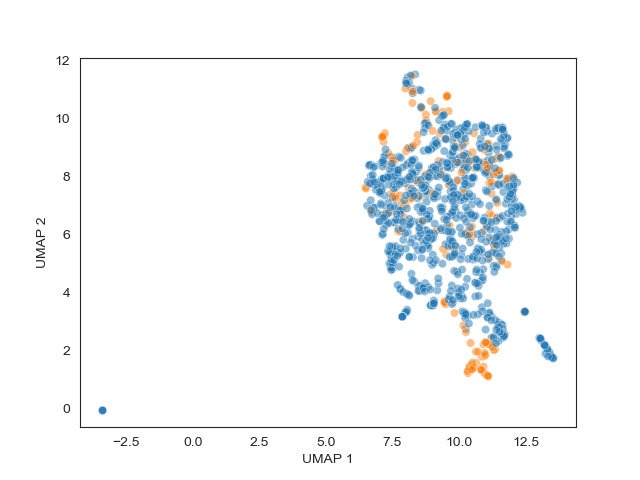

In [48]:
fig = plt.figure()
ax = sns.scatterplot(
        x=0,
        y=1,
        hue="Metadata_class",
        data=merged,
        alpha=(0.5),
        marker="o",
        legend=False
        )

ax.set_xlabel("UMAP 1", fontsize=10)
ax.set_ylabel("UMAP 2", fontsize=10)

fig.canvas.mpl_connect('pick_event', DataCursor(plt.gca()))
ax.set_picker(5) # Tolerance in points



In [15]:
A = ax.format_xdata


Text(0, 0.5, 'UMAP 2')

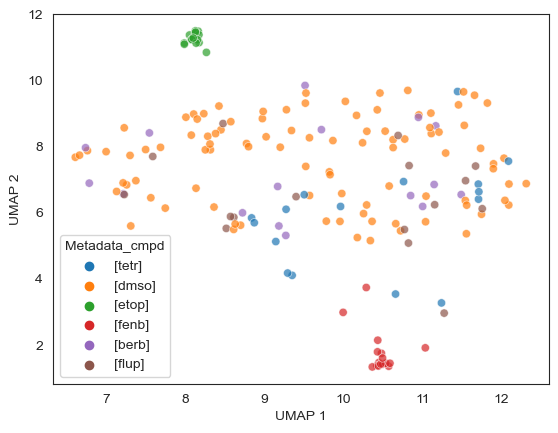

In [139]:
plt.figure()
ax = sns.scatterplot(
        x=0,
        y=1,
        hue="Metadata_cmpd",
        data=merged[merged['Metadata_pert_type'] != 'trt'],
        alpha=(0.7),
        marker="o",
        #legend=False
        )

ax.set_xlabel("UMAP 1", fontsize=10)
ax.set_ylabel("UMAP 2", fontsize=10)

In [27]:
merged = pd.merge(umapOut, df_toplot[ListOfMetadata], left_index=True, right_index=True)
merged['Metadata_inv_log_conc'] = 10 - pDose(merged['Metadata_cmpd_conc'])

In [28]:
ListOfSelectedFeatures = list(selected_df.columns.values)
ListOfMetadata = list(selected_df.columns[selected_df.columns.str.contains("Metadata_")])
ListOfSelectedFeatures = list(set(ListOfSelectedFeatures) - set(ListOfMetadata))

In [29]:
df_toplot = selected_df
ConcList = sorted(list(set(df_toplot["Metadata_cmpd_conc"])))
ConcList.remove(2.5)

df_toplot['Metadata_cmpd_conc'].loc[(df_toplot['Metadata_cmpd'] == '[dmso]')] = 100

/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_29947/2404014086.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toplot['Metadata_cmpd_conc'].loc[(df_toplot['Metadata_cmpd'] == '[dmso]')] = 100


In [30]:
training_data = df_toplot.drop(ListOfMetadata, axis=1).to_numpy()
umap_model = umap.UMAP(n_components=2, n_neighbors=10, min_dist= 0.1, random_state=42)
trained_model = umap_model.fit(training_data)
umapOut = trained_model.transform(training_data)
umapOut = pd.DataFrame(umapOut)

ValueError: num must be 1 <= num <= 6, not 7

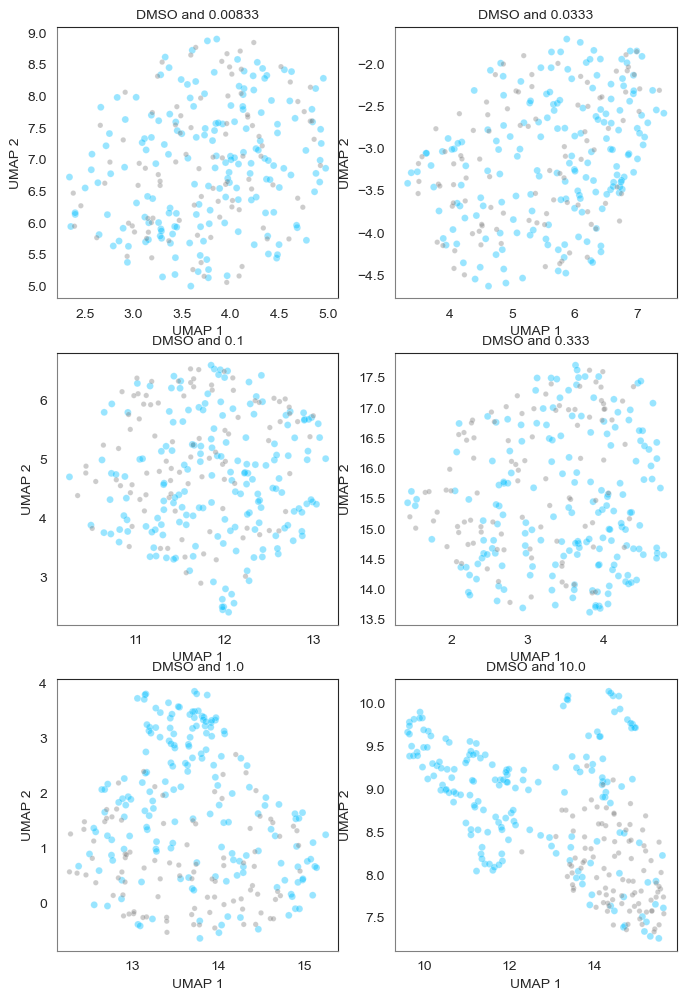

In [50]:
nrrow = 3
nrcol = 2
colors = ["deepskyblue", "gray"]

fig = plt.figure(figsize=(8, 12))
sp = 1
for conc in ConcList:
    dfOneCompound = df_toplot.loc[
        ((df_toplot["Metadata_cmpd_conc"] == conc)), ["Metadata_cmpd", "Metadata_cmpd_conc"] + ListOfSelectedFeatures
    ]
    dfDMSO = df_toplot.loc[
        ((df_toplot["Metadata_cmpd"] == "[dmso]")), ["Metadata_cmpd", "Metadata_cmpd_conc"] + ListOfSelectedFeatures
    ]
    frames = [dfOneCompound, dfDMSO]
    dfOneCompoundandDMSO = pd.concat(frames)
    dfOneCompoundandDMSO.reset_index(inplace=True, drop=True)

    x = dfOneCompoundandDMSO.loc[:, ListOfSelectedFeatures[:]].values
    umap_model = umap.UMAP(n_components=3, random_state=42)
    trained_model = umap_model.fit(x)
    principalComponents = trained_model.transform(x)
    principalDf = pd.DataFrame(data=principalComponents)
    principalDf.rename(
        columns={
            0: "principal component 1",
            1: "principal component 2",
            2: "principal component 3",
        },
        inplace=True,
    )
    principalDf = principalDf.merge(
        dfOneCompoundandDMSO[["Metadata_cmpd", "Metadata_cmpd_conc"]], left_index=True, right_index=True
    )
    # principalDf.to_csv('{}/PCA_dmso_and_{}.csv'.format(OutputDir, comp), sep=';')

    ax = fig.add_subplot(nrrow, nrcol, sp)
    ax.set_xlabel("UMAP 1", fontsize=10)
    ax.set_ylabel("UMAP 2", fontsize=10)
    ax.spines["left"].set_color("grey")
    ax.spines["bottom"].set_color("grey")
    x
    ax = sns.scatterplot(
        x="principal component 1",
        y="principal component 2",
        hue="Metadata_cmpd_conc",
        data=principalDf,
        palette=colors,
        size="Metadata_cmpd_conc",
        sizes=(25, 15),
        alpha=(0.4),
        marker="o",
    )

    ax.set_title("DMSO and {}".format(conc), fontsize=10)
    ax.set_facecolor("w")
    ax.get_legend().remove()
    sp += 1
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle("UMAP scores, DMSO and cons".format(), fontsize=12)
#fig.savefig(
#    "{}/PCA_DMSOandCons.{}".format(OutputDir, figformat), dpi=dpi, bbox_inches="tight"
#)
plt.show()